In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy.stats import multivariate_normal
from scipy.stats.distributions import chi2
from matplotlib.patches import Ellipse
np.random.seed(3698)

In [2]:
def plot_1d_gaussian(mean, var, w, ax, x_lim, **kwargs):
    x = np.linspace(*x_lim, 1000)
    y = w * multivariate_normal.pdf(x, mean=mean, cov=var)
    ax.plot(x, y, **kwargs)

def plot_1d_mixture_gaussian(means, vars, ws, ax, x_lim, **kwargs):
    x = np.linspace(*x_lim, 1000)
    y = np.zeros_like(x)
    for mean, var, w in zip(means, vars, ws):
        y += w * multivariate_normal.pdf(x, mean=mean, cov=var)
    ax.plot(x, y, **kwargs)

In [11]:
class SOT:
    def __init__(self, A, B, C, d, Sw, Sv, PD, ld, PG):
        # Motion model: x(t) = A x(t-1) + B u(t-1) + w(t-1), t=1..T
        # Motion noise: W ~ N(0, Sw)
        self.A = A
        self.B = B
        self.Sw = Sw

        # Measurement model: z(t) = C x(t) + d + v(t), t=0..T
        # Measurement noise: V ~ N(0, Sv)
        self.C = C
        self.d = d
        self.Sv = Sv

        # Shape:
        #   x, w: (n, )
        #   z, d, v: (m, )
        #   u: (p, )
        #   A: (n, n)
        #   B: (n, p)
        #   C: (m, n)
        #   Sw: (n, n)
        #   Sv: (m, m)
        self.n = A.shape[0]
        self.m = C.shape[0]

        # Probability of detection
        self.PD = PD

        # Clutter model
        self.ld = ld

        # Gating
        self.gate_size = chi2.ppf(PG, self.m)

    def state_predict(self, x_prev, P_prev, u):
        x_pred = self.A @ x_prev + self.B @ u
        P_pred = self.A @ P_prev @ self.A.T + self.Sw
        return x_pred, P_pred

    def measurement_predict(self, x_pred, P_pred):
        # Predict next measurement
        z_pred = self.C @ x_pred + self.d
        innov_cov = self.C @ P_pred @ self.C.T + self.Sv
        return z_pred, innov_cov
    
    def update(self, x_pred, P_pred, innov, innov_cov):
        # Calculate gain
        gain = P_pred @ self.C.T @ la.inv(innov_cov)

        # Update/Estimate
        x_upd = x_pred + gain @ innov
        P_upd = (np.eye(self.n) - gain @ self.C) @ P_pred

        return x_upd, P_upd

    def filter_GSF(self, z_obs, u_obs, x0, P0, max_hyp=5):
        # z_obs (T, m): observation
        # u_obs (T, p): control
        # x0 (n, ): prior mean
        # P0 (n, n): prior cov

        T = len(z_obs) + 1 # sequence length

        x_preds, P_preds = [[], [x0]], [[], [P0]]
        x_upds, P_upds, w_upds = [[]], [[]], [[1.0]]
        traces = [[], [[]]]

        for t in range(1, T):
            x_preds_new, P_preds_new, w_preds_new = [], [], []
            x_upds_new, P_upds_new, w_upds_new = [], [], []
            trace_new = []

            for i_prev, (x_pred, P_pred, w_pred, trace) in enumerate(zip(x_preds[-1], P_preds[-1], w_upds[-1], traces[-1])):
                # Prediction of measurement
                z_pred, innov_cov = \
                    self.measurement_predict(
                        x_pred,
                        P_pred
                    )
                inv_innov_cov = la.inv(innov_cov)

                # 3a. Update if undetected
                x_upd, P_upd = x_pred, P_pred
                w_upd = w_pred * (1 - self.PD)

                x_upds_new.append(x_upd)
                P_upds_new.append(P_upd)
                w_upds_new.append(w_upd)
                
                trace_ = [x for x in trace] + [0]
                trace_new.append(trace_)

                # 3b. Update if detected
                for i_cur, z in enumerate(z_obs[t-1], 1):
                    # Gating
                    if (z - z_pred).T @ inv_innov_cov @ (z - z_pred) > self.gate_size:
                        continue

                    x_upd, P_upd = \
                        self.update(
                            x_pred,
                            P_pred,
                            z - z_pred,
                            innov_cov
                        )
                    w_upd = w_pred * self.PD * multivariate_normal.pdf(z, mean=z_pred, cov=innov_cov) / self.ld

                    x_upds_new.append(x_upd)
                    P_upds_new.append(P_upd)
                    w_upds_new.append(w_upd)

                    trace_ = trace + [i_cur]
                    trace_new.append(trace_)

            w_upds_new = [x / sum(w_upds_new) for x in w_upds_new]

            # Merge
            def close(g1, g2):
                k = g1[1].shape[0]
                iS2 = la.inv(g2[2])
                dx = g1[1] - g2[1]
                tr = np.trace(iS2 @ g1[2])
                quad = dx.T @ iS2 @ dx
                det = np.log(la.det(g2[2]) / la.det(g1[2]))
                d = .5 * (tr + quad - k + det)
                return d < 0.1

            def merge(hyp, idx):
                ws, xs, Ps, trs = zip(*[hyp[i] for i in idx])
                w_merge = sum(ws)
                ws = [w / w_merge for w in ws]
                x_merge = sum([w * x for x, w in zip(xs, ws)])
                P_merge = sum([w * P for P, w in zip(Ps, ws)]) + \
                        sum([w * (x_merge - x) @ (x_merge - x).T for x, w in zip(xs, ws)])
                tr_merge = list(trs)
                return (w_merge, x_merge, P_merge, tr_merge)

            hyp = sorted(zip(w_upds_new, x_upds_new, P_upds_new, trace_new), reverse=True)
            hyp_GSF = []
            ignore_indices = []
            for i in range(len(hyp)):
                if i in ignore_indices:
                    continue
                merge_indices = [i]
                for j in range(i+1, len(hyp)):
                    if j not in ignore_indices and close(hyp[i], hyp[j]):
                        merge_indices.append(j)
                hyp_GSF.append(merge(hyp, merge_indices))
                ignore_indices.extend(merge_indices)

                if len(hyp_GSF) >= max_hyp:
                    break

            w_upds_GSF, x_upds_GSF, P_upds_GSF, trace_GSF = zip(*hyp_GSF)
            w_upds_GSF = [x / sum(w_upds_GSF) for x in w_upds_GSF]

            x_upds.append(x_upds_GSF)
            P_upds.append(P_upds_GSF)
            w_upds.append(w_upds_GSF)
            traces.append(trace_GSF)

            for i_prev, (x_prev, P_prev) in enumerate(zip(x_upds[-1], P_upds[-1])):
                # 1. Prediction of state
                x_pred, P_pred = \
                    self.state_predict(
                        x_prev,
                        P_prev,
                        u_obs[t-1]
                    )
                x_preds_new.append(x_pred)
                P_preds_new.append(P_pred)

            x_preds.append(x_preds_new)
            P_preds.append(P_preds_new)

        return x_preds, P_preds, x_upds, P_upds, w_upds, traces

    def filter(self, z_obs, u_obs, x0, P0):
        # z_obs (T, m): observation
        # u_obs (T, p): control
        # x0 (n, ): prior mean
        # P0 (n, n): prior cov

        T = len(z_obs) + 1 # sequence length

        x_preds, P_preds = [[], [x0]], [[], [P0]]
        x_upds, P_upds, w_upds = [[]], [[]], [[1.0]]
        traces = [[], [[]]]

        for t in range(1, T):
            x_preds_new, P_preds_new, w_preds_new = [], [], []
            x_upds_new, P_upds_new, w_upds_new = [], [], []
            trace_new = []

            for i_prev, (x_pred, P_pred, w_pred, trace) in enumerate(zip(x_preds[-1], P_preds[-1], w_upds[-1], traces[-1])):
                # Prediction of measurement
                z_pred, innov_cov = \
                    self.measurement_predict(
                        x_pred,
                        P_pred
                    )

                # 3a. Update if undetected
                x_upd, P_upd = x_pred, P_pred
                w_upd = w_pred * (1 - self.PD)

                x_upds_new.append(x_upd)
                P_upds_new.append(P_upd)
                w_upds_new.append(w_upd)
                
                trace_ = [x for x in trace] + [0]
                trace_new.append(trace_)

                # 3b. Update if detected
                for i_cur, z in enumerate(z_obs[t-1], 1):
                    x_upd, P_upd = \
                        self.update(
                            x_pred,
                            P_pred,
                            z - z_pred,
                            innov_cov
                        )
                    w_upd = w_pred * self.PD * multivariate_normal.pdf(z, mean=z_pred, cov=innov_cov) / self.ld

                    x_upds_new.append(x_upd)
                    P_upds_new.append(P_upd)
                    w_upds_new.append(w_upd)

                    trace_ = trace + [i_cur]
                    trace_new.append(trace_)

            x_upds.append(x_upds_new)
            P_upds.append(P_upds_new)
            w_upds_new = [x / sum(w_upds_new) for x in w_upds_new]
            w_upds.append(w_upds_new)
            traces.append(trace_new)

            for i_prev, (x_prev, P_prev) in enumerate(zip(x_upds[-1], P_upds[-1])):
                # 1. Prediction of state
                x_pred, P_pred = \
                    self.state_predict(
                        x_prev,
                        P_prev,
                        u_obs[t-1]
                    )
                x_preds_new.append(x_pred)
                P_preds_new.append(P_pred)

            x_preds.append(x_preds_new)
            P_preds.append(P_preds_new)

        return x_preds, P_preds, x_upds, P_upds, w_upds, traces

    def filter_NN(self, z_obs, u_obs, x0, P0):
        # z_obs (T, m): observation
        # u_obs (T, p): control
        # x0 (n, ): prior mean
        # P0 (n, n): prior cov

        T = len(z_obs) + 1 # sequence length

        x_preds, P_preds = [[], [x0]], [[], [P0]]
        x_upds, P_upds, w_upds = [[]], [[]], [[1.0]]
        traces = [[], [[]]]

        for t in range(1, T):
            x_preds_new, P_preds_new = [], []
            x_upds_new, P_upds_new, w_upds_new = [], [], []
            trace_new = []

            for i_prev, (x_pred, P_pred, w_pred, trace) in enumerate(zip(x_preds[-1], P_preds[-1], w_upds[-1], traces[-1])):
                # Prediction of measurement
                z_pred, innov_cov = self.measurement_predict(x_pred, P_pred)
                inv_innov_cov = la.inv(innov_cov)

                theta_nn = 0
                w_best = w_pred * (1 - self.PD)
                for theta, z in enumerate(z_obs[t-1], 1):
                    # Gating
                    if (z - z_pred).T @ inv_innov_cov @ (z - z_pred) > self.gate_size:
                        continue

                    w_upd = w_pred * self.PD * multivariate_normal.pdf(z, mean=z_pred, cov=innov_cov) / self.ld
                    if w_upd > w_best:
                        theta_nn = theta
                        w_best = w_upd
                
                if theta_nn == 0:
                    # 3a. Update if undetected
                    x_upd, P_upd = x_pred, P_pred
                else:
                    # 3b. Update if detected
                    x_upd, P_upd = \
                        self.update(
                            x_pred, P_pred,
                            z_obs[t-1][theta_nn - 1] - z_pred,
                            innov_cov
                        )
                x_upds_new.append(x_upd)
                P_upds_new.append(P_upd)

                trace_ = trace + [theta_nn]
                trace_new.append(trace_)

            x_upds.append(x_upds_new)
            P_upds.append(P_upds_new)
            w_upds.append([1.0])
            traces.append(trace_new)

            for _, (x_prev, P_prev) in enumerate(zip(x_upds[-1], P_upds[-1])):
                # 1. Prediction of state
                x_pred, P_pred = \
                    self.state_predict(
                        x_prev, P_prev,
                        u_obs[t-1]
                    )
                x_preds_new.append(x_pred)
                P_preds_new.append(P_pred)

            x_preds.append(x_preds_new)
            P_preds.append(P_preds_new)

        return x_preds, P_preds, x_upds, P_upds, w_upds, traces

    def filter_PDA(self, z_obs, u_obs, x0, P0):
        # z_obs (T, m): observation
        # u_obs (T, p): control
        # x0 (n, ): prior mean
        # P0 (n, n): prior cov

        T = len(z_obs) + 1 # sequence length

        x_preds, P_preds = [[], [x0]], [[], [P0]]
        x_upds, P_upds, w_upds = [[]], [[]], [[1.0]]
        traces = [[], [[]]]

        for t in range(1, T):
            x_preds_new, P_preds_new, w_preds_new = [], [], []
            x_upds_new, P_upds_new, w_upds_new = [], [], []
            trace_new = []

            for i_prev, (x_pred, P_pred, w_pred, trace) in enumerate(zip(x_preds[-1], P_preds[-1], w_upds[-1], traces[-1])):
                # Prediction of measurement
                z_pred, innov_cov = \
                    self.measurement_predict(
                        x_pred,
                        P_pred
                    )
                inv_innov_cov = la.inv(innov_cov)

                # 3a. Update if undetected
                x_upd, P_upd = x_pred, P_pred
                w_upd = w_pred * (1 - self.PD)

                x_upds_new.append(x_upd)
                P_upds_new.append(P_upd)
                w_upds_new.append(w_upd)
                
                trace_ = [x for x in trace] + [0]
                trace_new.append(trace_)

                # 3b. Update if detected
                for i_cur, z in enumerate(z_obs[t-1], 1):
                    # Gating
                    if (z - z_pred).T @ inv_innov_cov @ (z - z_pred) > self.gate_size:
                        continue

                    x_upd, P_upd = \
                        self.update(
                            x_pred,
                            P_pred,
                            z - z_pred,
                            innov_cov
                        )
                    w_upd = w_pred * self.PD * multivariate_normal.pdf(z, mean=z_pred, cov=innov_cov) / self.ld

                    x_upds_new.append(x_upd)
                    P_upds_new.append(P_upd)
                    w_upds_new.append(w_upd)

                    trace_ = trace + [0]
                    trace_new.append(trace_)
            
            w_upds_new = [x / sum(w_upds_new) for x in w_upds_new]
            x_PDA = sum([w * x for x, w in zip(x_upds_new, w_upds_new)])
            P_PDA = sum([w * P for P, w in zip(P_upds_new, w_upds_new)]) + \
                    sum([w * (x_PDA - x) @ (x_PDA - x).T for x, w in zip(x_upds_new, w_upds_new)])

            x_upds.append([x_PDA])
            P_upds.append([P_PDA])
            w_upds.append([1.0])
            traces.append(trace_new)

            for i_prev, (x_prev, P_prev) in enumerate(zip(x_upds[-1], P_upds[-1])):
                # 1. Prediction of state
                x_pred, P_pred = \
                    self.state_predict(
                        x_prev,
                        P_prev,
                        u_obs[t-1]
                    )
                x_preds_new.append(x_pred)
                P_preds_new.append(P_pred)

            x_preds.append(x_preds_new)
            P_preds.append(P_preds_new)

        return x_preds, P_preds, x_upds, P_upds, w_upds, traces

In [12]:
# Motion model
A = np.array([[1.]])
B = np.zeros((1, 1))
Sw = np.array([[0.35]])

# Measurement model
C = np.array([[1.]])
d = np.zeros(1)
Sv = np.array([[0.2]])

# Detection probability
det_prob = 0.9

# Clutter model
ld = 0.4

# Gating
PG = 0.995

sot = SOT(A, B, C, d, Sw, Sv, det_prob, ld, PG)

In [13]:
# Initial
x0 = np.array([0.5])
P0 = np.array([[0.2]])

# Observations
z_obs = [
    [np.array([-1.3]), np.array([1.7])],
    [np.array([ 1.3])],
    [np.array([-0.3]), np.array([2.3])],
    [np.array([-2.0]), np.array([3.0])],
    [np.array([ 2.6])],
    [np.array([-3.5]), np.array([2.8])]
]
T = len(z_obs)
u_obs = np.zeros((T, 1))

x_preds, P_preds, x_upds, P_upds, w_upds, traces = sot.filter(z_obs, u_obs, x0, P0)
x_preds_PDA, P_preds_PDA, x_upds_PDA, P_upds_PDA, w_upds_PDA, traces_PDA = sot.filter_PDA(z_obs, u_obs, x0, P0)
x_preds_NN, P_preds_NN, x_upds_NN, P_upds_NN, w_upds_NN, traces_NN = sot.filter_NN(z_obs, u_obs, x0, P0)
x_preds_GSF, P_preds_GSF, x_upds_GSF, P_upds_GSF, w_upds_GSF, traces_GSF = sot.filter_GSF(z_obs, u_obs, x0, P0)

1 0 1
4 0 1
4 1 2
4 2 1
4 3 2
5 4 1
6 0 1
6 1 1
6 2 1
6 3 1
6 4 1


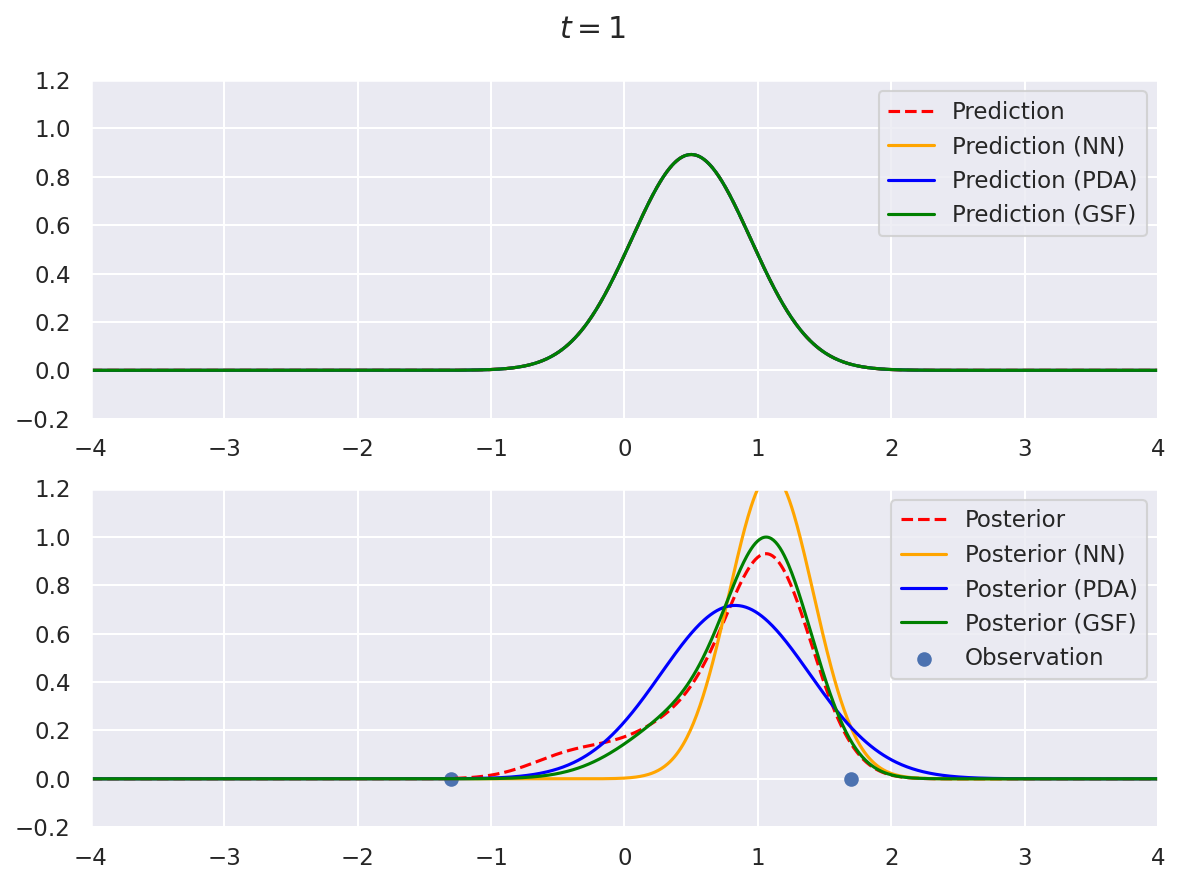

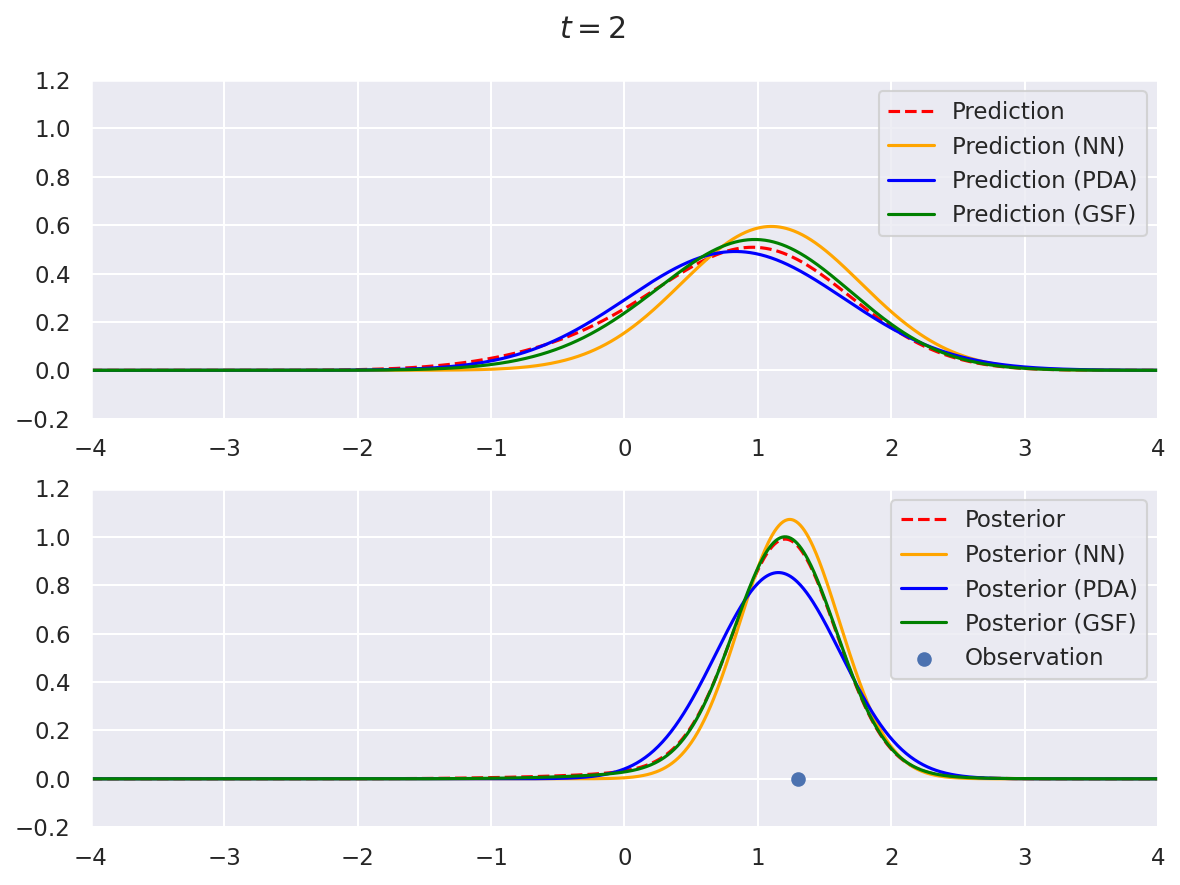

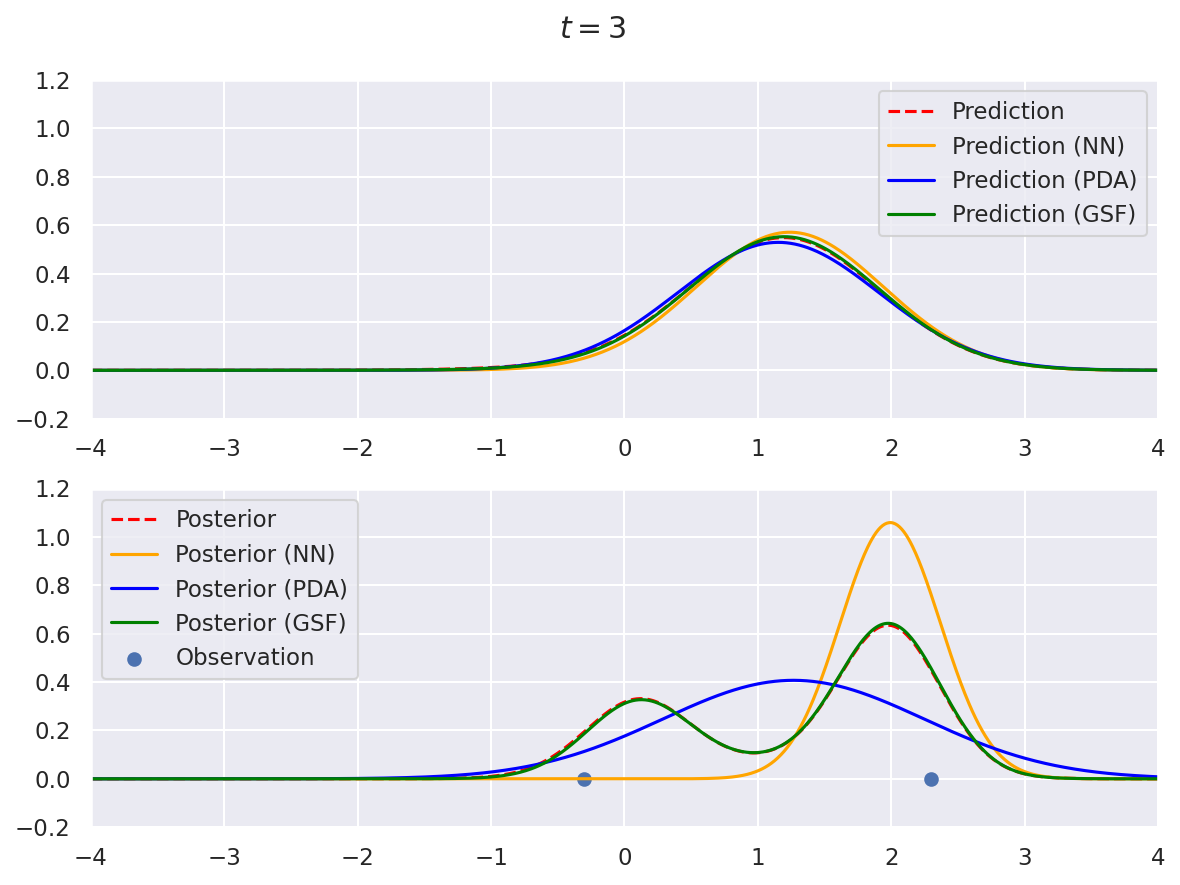

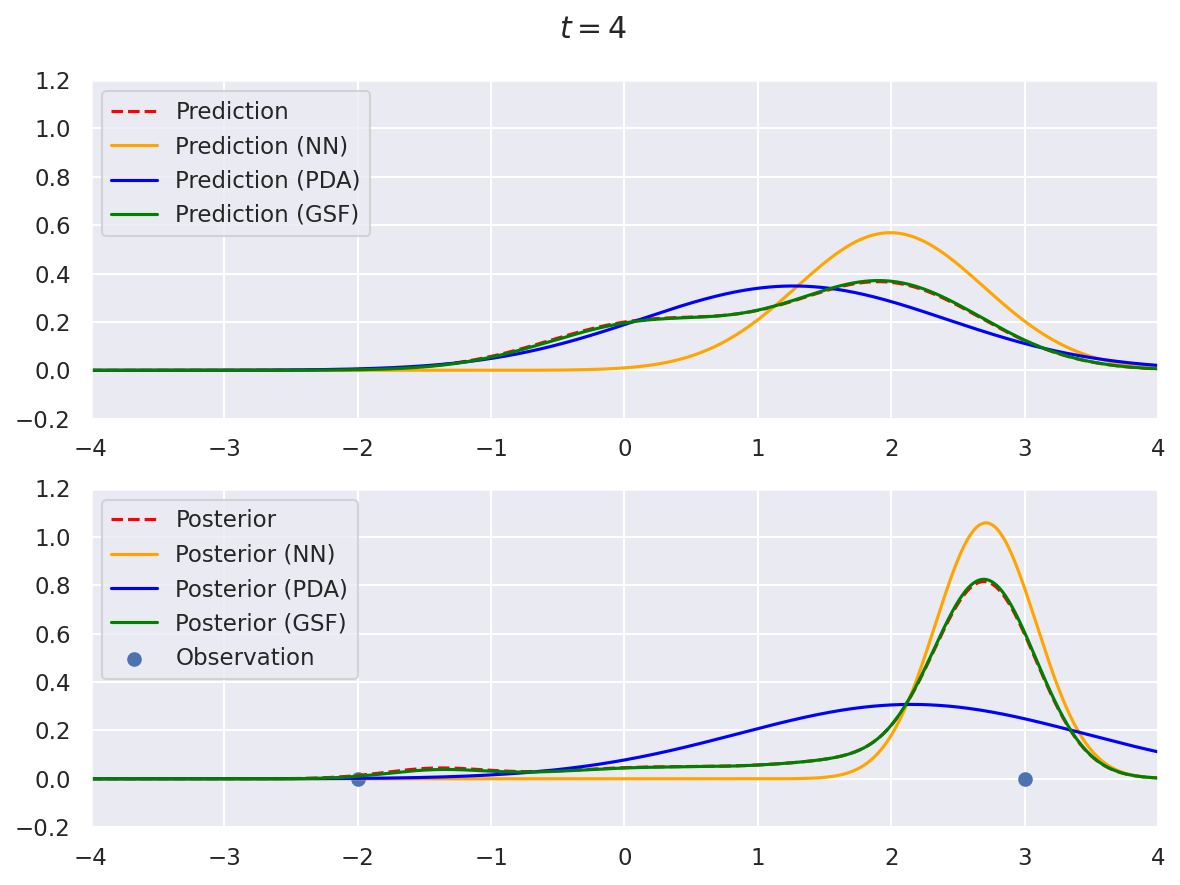

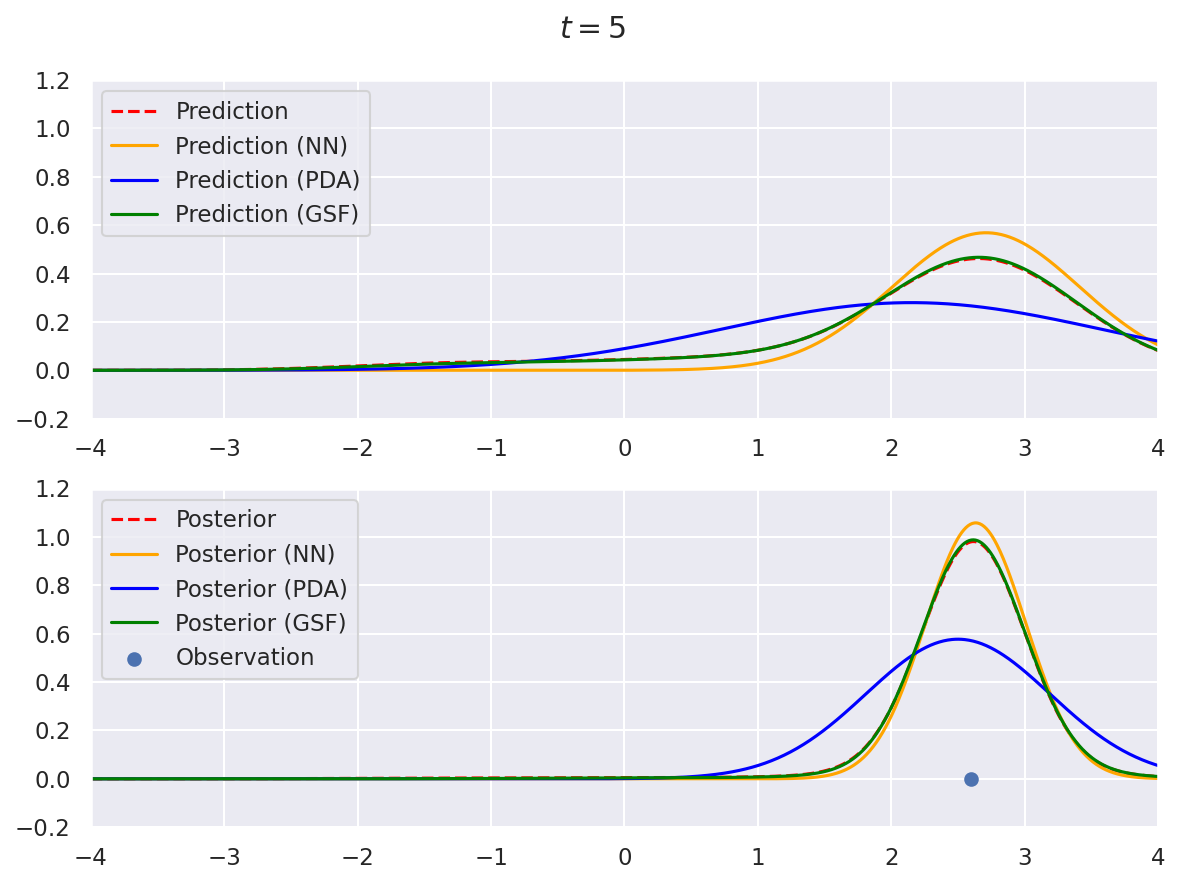

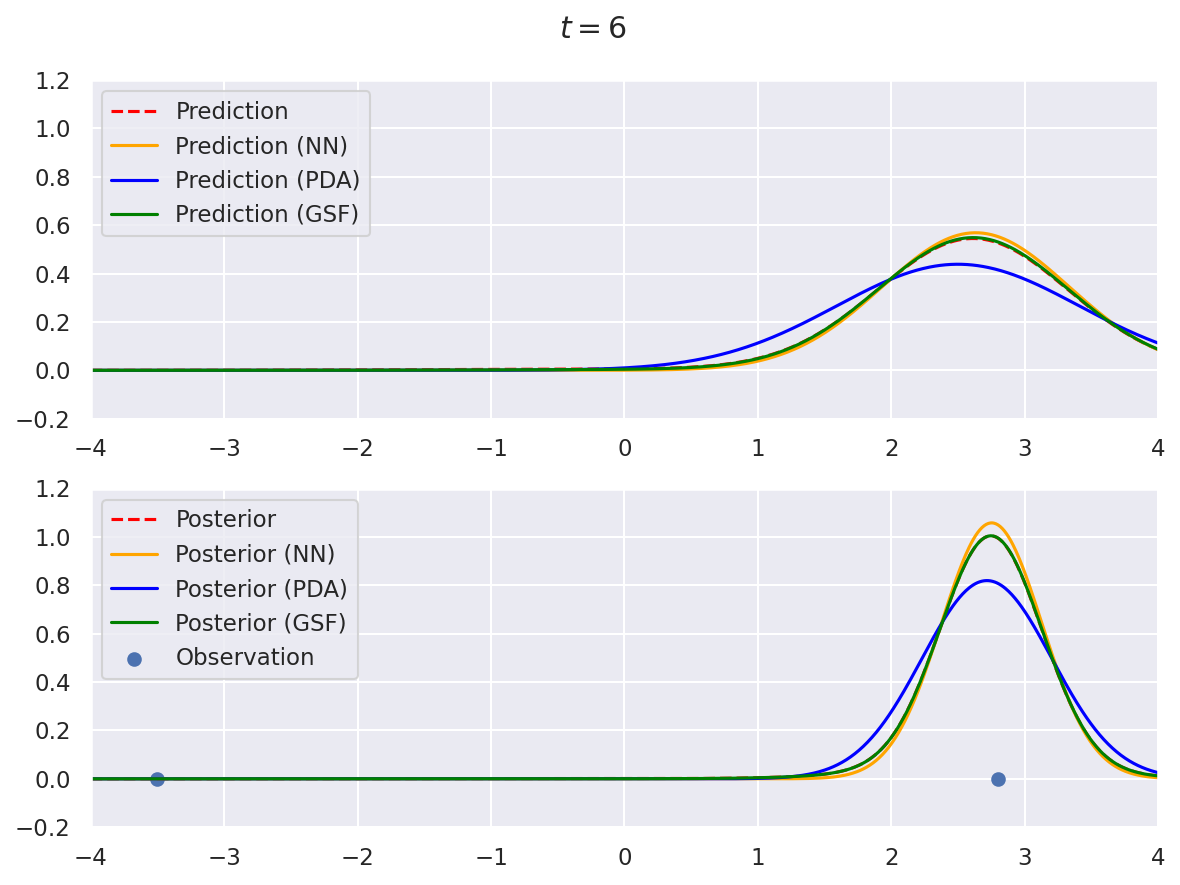

In [14]:
for t in range(1, T+1):
    fig, ax = plt.subplots(2, 1, figsize=(8, 6), dpi=150)

    xlim = (-4, 4)

    plot_1d_mixture_gaussian(x_preds[t], P_preds[t], w_upds[t-1], ax[0], xlim, color='red', linestyle='dashed', label='Prediction')
    plot_1d_mixture_gaussian(x_preds_NN[t], P_preds_NN[t], w_upds_NN[t-1], ax[0], xlim, color='orange', linestyle='solid', label='Prediction (NN)')
    plot_1d_mixture_gaussian(x_preds_PDA[t], P_preds_PDA[t], w_upds_PDA[t-1], ax[0], xlim, color='blue', linestyle='solid', label='Prediction (PDA)')
    plot_1d_mixture_gaussian(x_preds_GSF[t], P_preds_GSF[t], w_upds_GSF[t-1], ax[0], xlim, color='green', linestyle='solid', label='Prediction (GSF)')

    plot_1d_mixture_gaussian(x_upds[t], P_upds[t], w_upds[t], ax[1], xlim, color='red', linestyle='dashed', label='Posterior')
    plot_1d_mixture_gaussian(x_upds_NN[t], P_upds_NN[t], w_upds_NN[t], ax[1], xlim, color='orange', linestyle='solid', label='Posterior (NN)')
    plot_1d_mixture_gaussian(x_upds_PDA[t], P_upds_PDA[t], w_upds_PDA[t], ax[1], xlim, color='blue', linestyle='solid', label='Posterior (PDA)')
    plot_1d_mixture_gaussian(x_upds_GSF[t], P_upds_GSF[t], w_upds_GSF[t], ax[1], xlim, color='green', linestyle='solid', label='Posterior (GSF)')
    ax[1].scatter(z_obs[t-1], np.zeros(len(z_obs[t-1])), label='Observation')

    ax[0].set_xlim(xlim)
    ax[0].set_ylim((-0.2, 1.2))
    ax[0].legend()

    ax[1].set_xlim(xlim)
    ax[1].set_ylim((-0.2, 1.2))
    ax[1].legend()

    fig.suptitle(f'$t={t}$')
    plt.tight_layout()
    plt.show()


In [15]:
# Initial
x0 = np.array([0.5])
P0 = np.array([[0.2]])

# Observations
z_obs = [
    [np.array([-1.3]), np.array([1.7])],
    [np.array([ 1.3])],
    [np.array([-0.3]), np.array([2.3])],
    [np.array([-0.7]), np.array([3.0])],
    [np.array([-1.0])],
    [np.array([-1.3])]
]
T = len(z_obs)
u_obs = np.zeros((T, 1))

x_preds, P_preds, x_upds, P_upds, w_upds, traces = sot.filter(z_obs, u_obs, x0, P0)
x_preds_PDA, P_preds_PDA, x_upds_PDA, P_upds_PDA, w_upds_PDA, traces_PDA = sot.filter_PDA(z_obs, u_obs, x0, P0)
x_preds_NN, P_preds_NN, x_upds_NN, P_upds_NN, w_upds_NN, traces_NN = sot.filter_NN(z_obs, u_obs, x0, P0)
x_preds_GSF, P_preds_GSF, x_upds_GSF, P_upds_GSF, w_upds_GSF, traces_GSF = sot.filter_GSF(z_obs, u_obs, x0, P0)

1 0 1
4 0 1
4 1 2
4 3 2
5 0 1
5 2 1
6 1 1


In [16]:
print([len(x) for x in traces])
print([len(x) for x in traces_GSF])

[0, 1, 3, 6, 18, 54, 108, 216]
[0, 1, 2, 3, 5, 5, 5, 5]


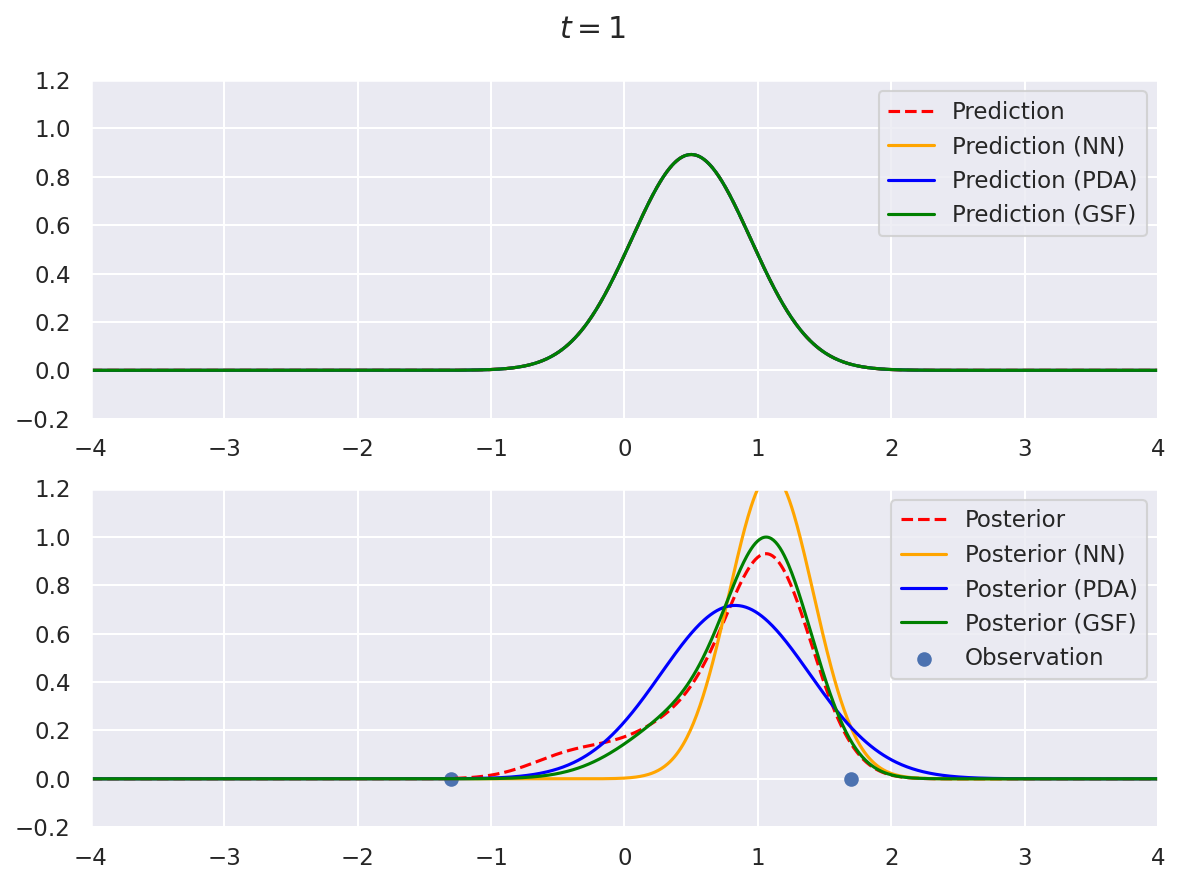

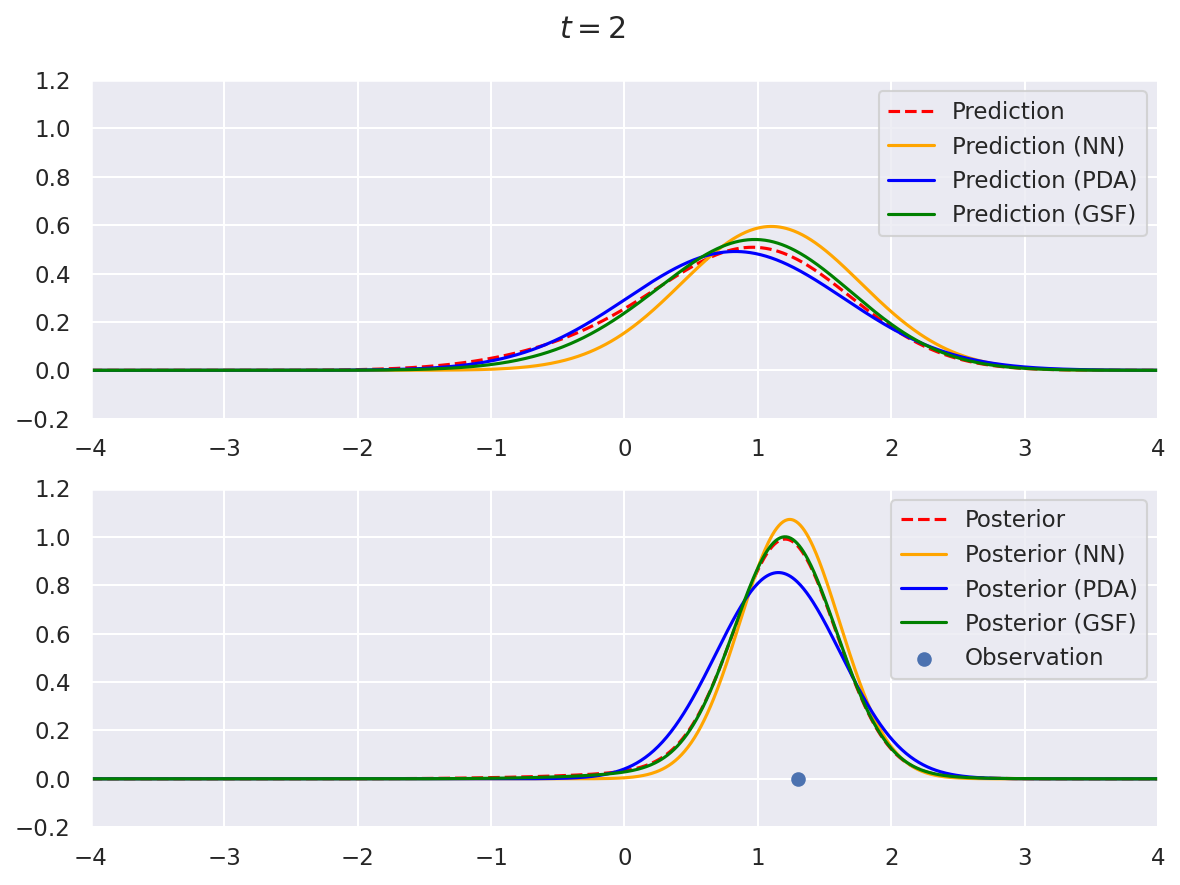

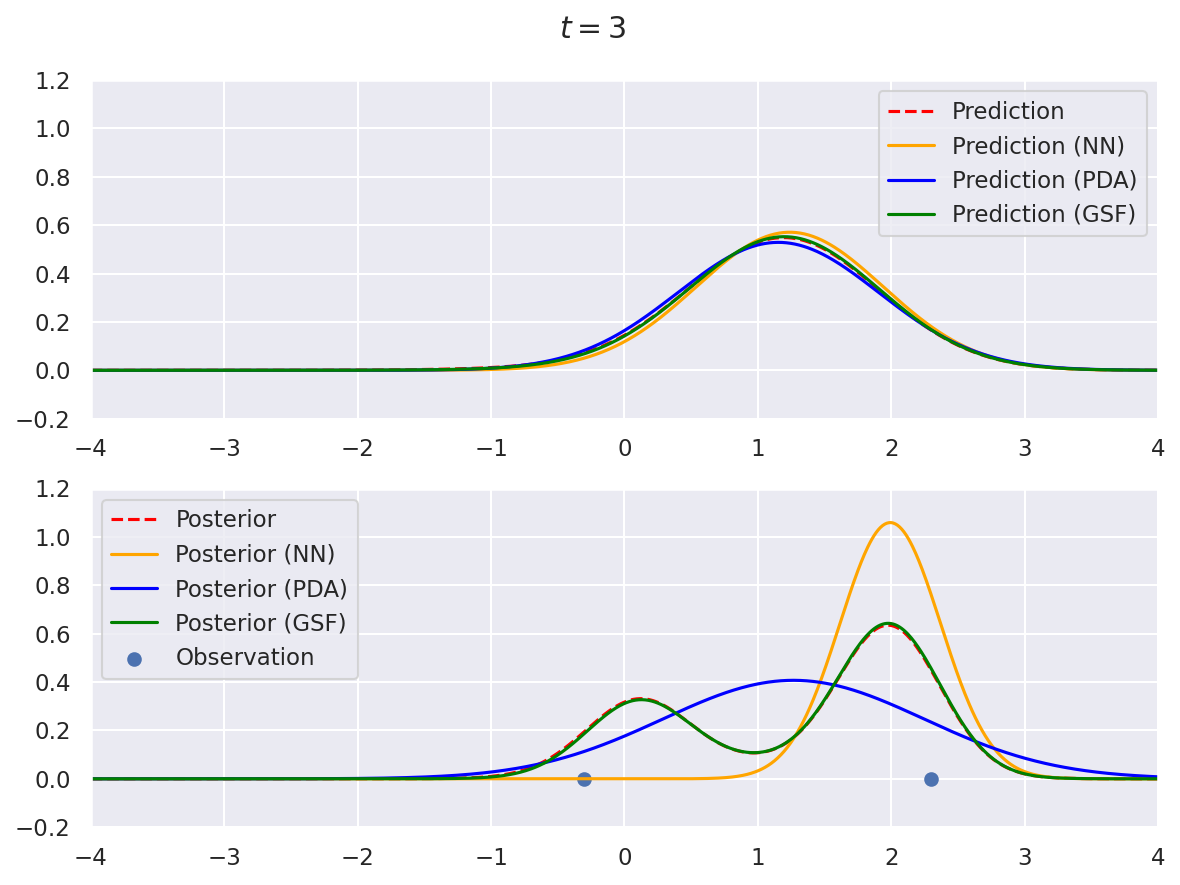

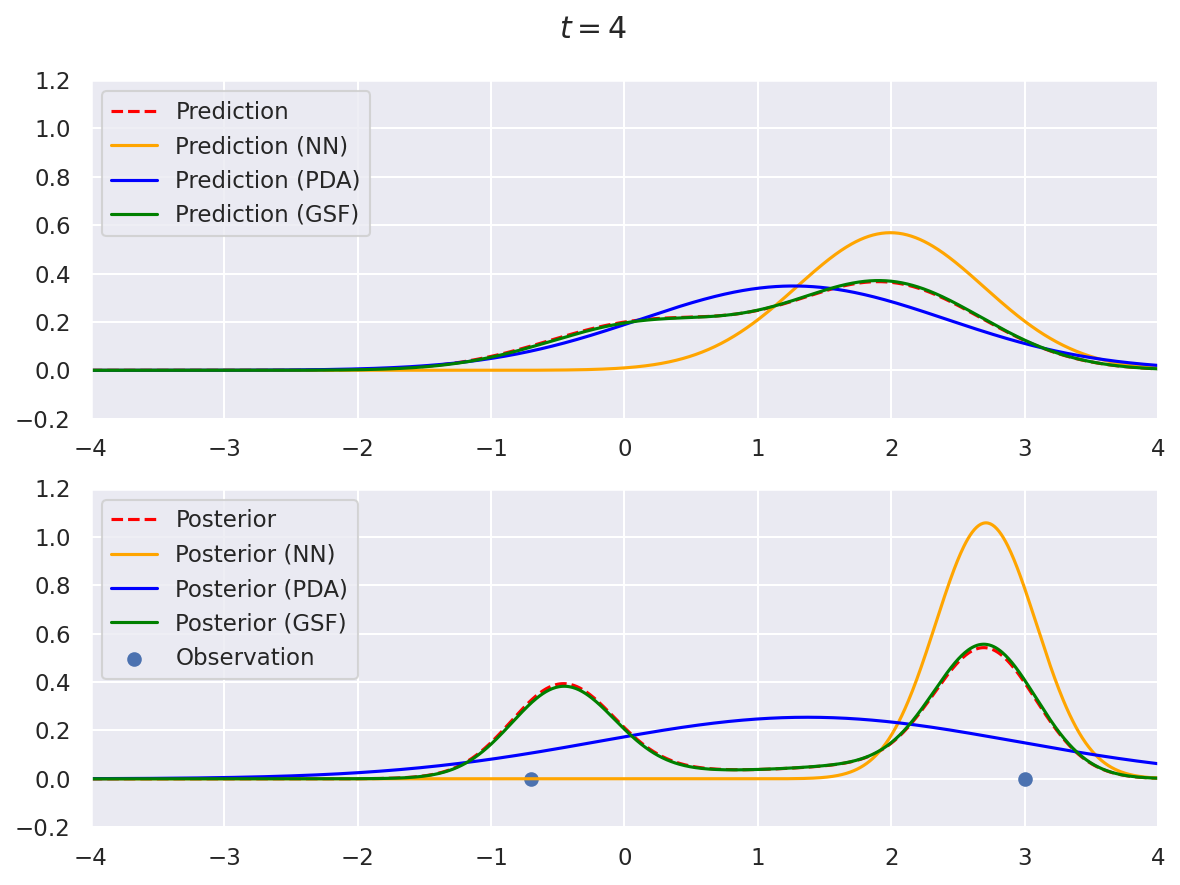

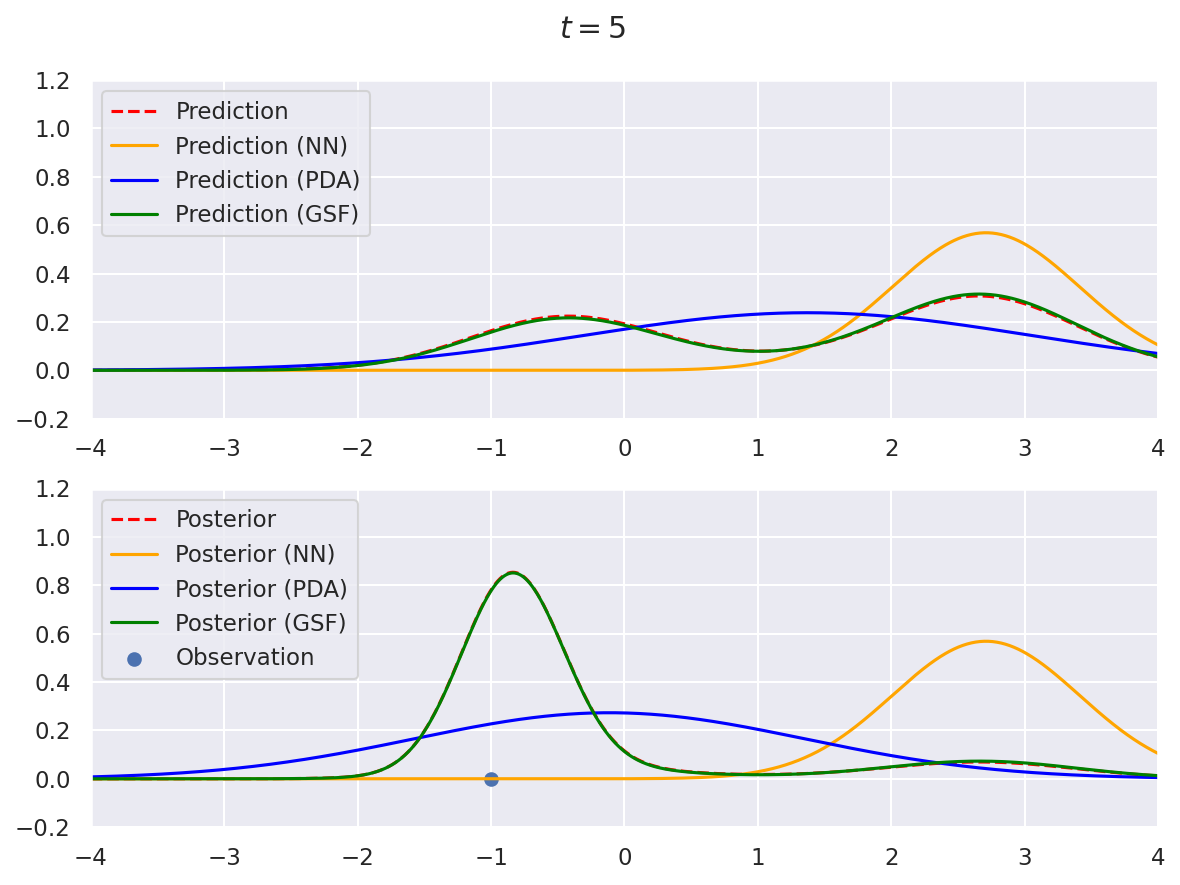

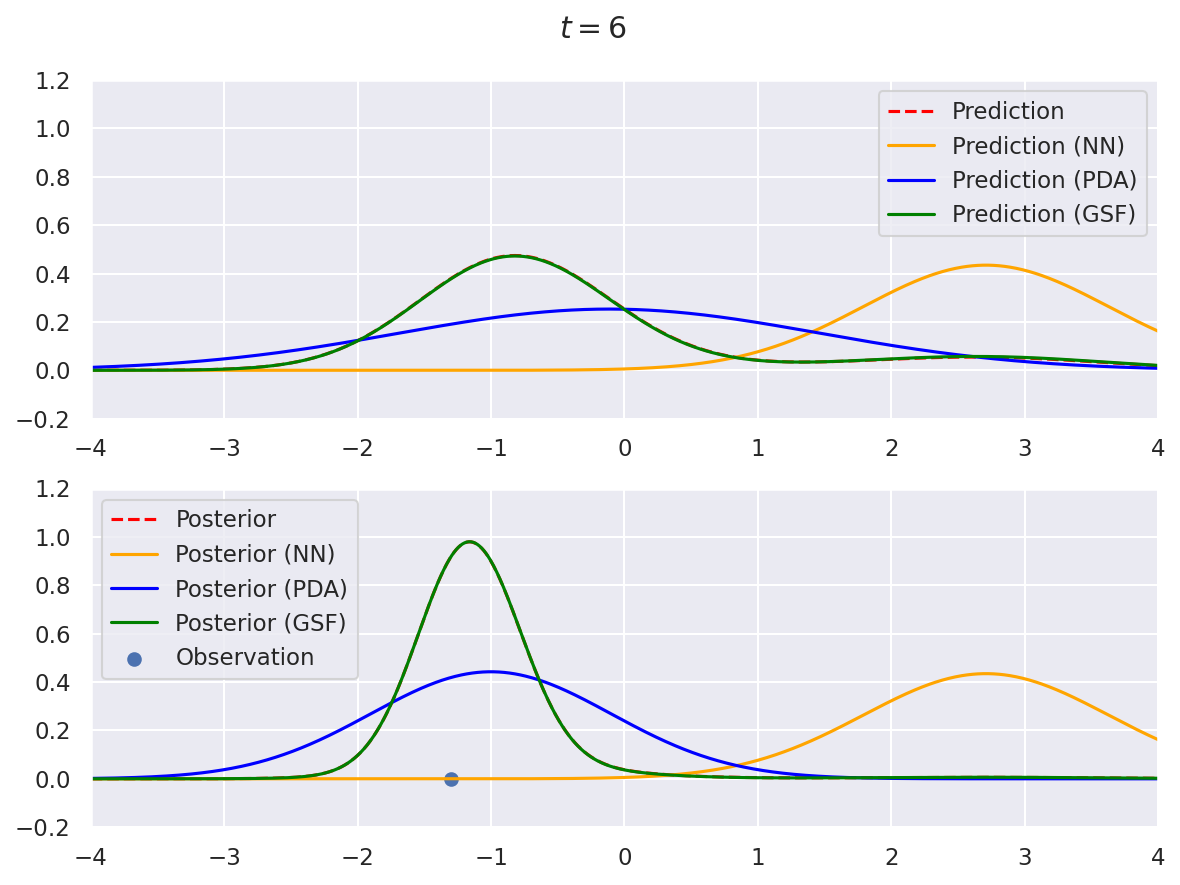

In [17]:
for t in range(1, T+1):
    fig, ax = plt.subplots(2, 1, figsize=(8, 6), dpi=150)

    xlim = (-4, 4)

    plot_1d_mixture_gaussian(x_preds[t], P_preds[t], w_upds[t-1], ax[0], xlim, color='red', linestyle='dashed', label='Prediction')
    plot_1d_mixture_gaussian(x_preds_NN[t], P_preds_NN[t], w_upds_NN[t-1], ax[0], xlim, color='orange', linestyle='solid', label='Prediction (NN)')
    plot_1d_mixture_gaussian(x_preds_PDA[t], P_preds_PDA[t], w_upds_PDA[t-1], ax[0], xlim, color='blue', linestyle='solid', label='Prediction (PDA)')
    plot_1d_mixture_gaussian(x_preds_GSF[t], P_preds_GSF[t], w_upds_GSF[t-1], ax[0], xlim, color='green', linestyle='solid', label='Prediction (GSF)')

    plot_1d_mixture_gaussian(x_upds[t], P_upds[t], w_upds[t], ax[1], xlim, color='red', linestyle='dashed', label='Posterior')
    plot_1d_mixture_gaussian(x_upds_NN[t], P_upds_NN[t], w_upds_NN[t], ax[1], xlim, color='orange', linestyle='solid', label='Posterior (NN)')
    plot_1d_mixture_gaussian(x_upds_PDA[t], P_upds_PDA[t], w_upds_PDA[t], ax[1], xlim, color='blue', linestyle='solid', label='Posterior (PDA)')
    plot_1d_mixture_gaussian(x_upds_GSF[t], P_upds_GSF[t], w_upds_GSF[t], ax[1], xlim, color='green', linestyle='solid', label='Posterior (GSF)')
    ax[1].scatter(z_obs[t-1], np.zeros(len(z_obs[t-1])), label='Observation')

    ax[0].set_xlim(xlim)
    ax[0].set_ylim((-0.2, 1.2))
    ax[0].legend()

    ax[1].set_xlim(xlim)
    ax[1].set_ylim((-0.2, 1.2))
    ax[1].legend()

    fig.suptitle(f'$t={t}$')
    plt.tight_layout()
    plt.show()
